## Exercise 8: Differential analysis of protein expression from breast cancer subtypes
For this lesson, we will take the quantitative proteomics data from the following publication, "Proteogenomic Landscape of Breast Cancer Tumorigenesis and Targeted Therapy" (Cell, 2020).

Here is the author's summary of the work:

The integration of mass spectrometry-based proteomics with next-generation DNA and RNA sequencing profiles tumors more comprehensively. Here this “proteogenomics” approach was applied to 122 treatment-naive primary breast cancers accrued to preserve post-translational modifications, including protein phosphorylation and acetylation. Proteogenomics challenged standard breast cancer diagnoses, provided detailed analysis of the ERBB2 amplicon, defined tumor subsets that could benefit from immune checkpoint therapy, and allowed more accurate assessment of Rb status for prediction of CDK4/6 inhibitor responsiveness. Phosphoproteomics profiles uncovered novel associations between tumor suppressor loss and targetable kinases. Acetylproteome analysis highlighted acetylation on key nuclear proteins involved in the DNA damage response and revealed cross-talk between cytoplasmic and mitochondrial acetylation and metabolism. Our results underscore the potential of proteogenomics for clinical investigation of breast cancer through more accurate annotation of targetable pathways and biological features of this remarkably heterogeneous malignancy.


Today we will use the underlying data to learn about what proteins are changing between the Luminal A and Luminal B samples of breast cancer that were examined in this study.

### Import the required libraries

In [24]:
import numpy as np, pandas as pd, seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.stats.multitest
from scipy.stats import ttest_ind
import sklearn.inspection, sklearn.metrics, sklearn.neighbors, sklearn.svm, sklearn.pipeline, sklearn.preprocessing

#Fix `RANDOM_SEED` for (partial) reproducibility
RANDOM_SEED = 4


def plot_question_mark(ax):
  ax.text(x=.5, y=.5, s='?', color='red', fontsize=64,
          horizontalalignment='center',
          verticalalignment='center',
          transform=ax.transAxes)

### Load the z-score normalized data into a pandas DataFrame


In [25]:
df = pd.read_csv('CPTAC_2020_BR_proteomics_annotated.csv', low_memory = False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10107 entries, 0 to 10106
Columns: 135 entries, id to LumA.56
dtypes: float64(126), int64(3), object(6)
memory usage: 10.4+ MB


**<span style="font-size:large;"><u>Question 1</u></span>**: <span style="font-size:large;">Why is this data z-scored?</span>


### Answer 1
The data is z-scored, so that we can look at proteins with different intensities and standard deviations on a common scale.

### Move forward with only complete data

Let's have a look at our unfilterede data:

In [26]:
df.head()

,id,geneSymbol,numColumnsProteinObserved,numSpectraProteinObserved,protein_mw,percentCoverage,numPepsUnique,scoreUnique,species,accession_number,...,Basal.25,Basal.26,Basal.27,Basal.28,Her2.13,LumB.16,LumA.53,LumA.54,LumA.55,LumA.56
0,NP_001254479.2,TTN,17,1654,4024362.5,33.2,937,12052.01,HOMO SAPIENS,NP_001254479.2,...,-1.6431,0.4284,-0.9533,0.1671,-0.5536,-0.1280,-0.5201,0.3733,-1.2496,0.9134
1,NP_001243779.1,TTN,16,26,3845227.7,34.6,933,12030.29,HOMO SAPIENS,NP_001243779.1,...,0.9424,-0.5008,-0.5097,0.0209,2.9257,-1.5503,-1.8120,-1.1813,4.7892,-1.5291
2,NP_596870.2,TTN,14,22,635321.0,22.4,100,1256.55,HOMO SAPIENS,NP_596870.2,...,1.6571,NaN,NaN,0.3500,-1.1689,-9.0546,-9.4247,-4.6253,-10.4715,-0.3749
3,NP_569827.2,MADD,14,20,174704.6,56.8,75,1053.38,HOMO SAPIENS,NP_569827.2,...,-6.8095,-2.1628,-0.3971,NaN,-5.9584,0.1424,2.1085,2.7050,NaN,3.3441
4,NP_036555.1,RPL13A,17,535,23633.9,74.8,26,305.51,HOMO SAPIENS,NP_036555.1,...,-1.5926,0.7230,-0.1084,1.0841,-0.4741,0.6521,0.1706,-0.6952,0.2070,-0.7656


We can see th presence of NaNs, which are de facto missing values in our table.

We could "gap-fill" these missing values using machine learning or simple imputation to include proteins with missing values; however, here with over 7,000 proteins quantified in union, it is  enough for us to move forward and try to make some conclusions for the class.


We will only take proteins that were identified in all samples, and exlude those with missing quantification values.

As an aside, some proteins may not be identified or quantified in a particular sample for a number of reasons. It is possible that the underlying biology of the tumor sample is different, or that the protein was below the limit of detection of the mass spectrometer used to identify the peptides from the given protein. Additionally, there are a number of possible explanaitions stemming from the analytical chemistry and the study design that we will not cover.

In [27]:
df.replace(r'\s+', np.nan, regex=True)
df.dropna(axis = 0, how = 'any', inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7767 entries, 0 to 10102
Columns: 135 entries, id to LumA.56
dtypes: float64(126), int64(3), object(6)
memory usage: 8.1+ MB


In [28]:
df.head()

,id,geneSymbol,numColumnsProteinObserved,numSpectraProteinObserved,protein_mw,percentCoverage,numPepsUnique,scoreUnique,species,accession_number,...,Basal.25,Basal.26,Basal.27,Basal.28,Her2.13,LumB.16,LumA.53,LumA.54,LumA.55,LumA.56
0,NP_001254479.2,TTN,17,1654,4024362.5,33.2,937,12052.01,HOMO SAPIENS,NP_001254479.2,...,-1.6431,0.4284,-0.9533,0.1671,-0.5536,-0.1280,-0.5201,0.3733,-1.2496,0.9134
4,NP_036555.1,RPL13A,17,535,23633.9,74.8,26,305.51,HOMO SAPIENS,NP_036555.1,...,-1.5926,0.7230,-0.1084,1.0841,-0.4741,0.6521,0.1706,-0.6952,0.2070,-0.7656
6,NP_056651.1,WARS2,17,206,40317.0,67.5,23,375.02,HOMO SAPIENS,NP_056651.1,...,2.2662,-1.1455,-0.4487,-1.5290,0.2817,1.0603,-1.6125,1.0569,2.5772,0.2931
7,NP_001611.1,AHNAK,17,15838,629603.7,78.8,668,11806.33,HOMO SAPIENS,NP_001611.1,...,0.1541,-0.1558,-0.8900,0.2853,2.0267,1.5439,1.1842,0.4430,-0.1239,-0.6344
8,NP_076965.2,AHNAK,16,49,16174.6,89.9,11,217.35,HOMO SAPIENS,NP_076965.2,...,-0.5790,-0.8080,-1.3523,0.9603,1.8517,3.6891,-1.1398,-1.6517,-1.2856,-0.7776


### Define and compare the two groups
Here we will move forward with the tumors annotated clinically as **luminal A** (HER2-, hormone receptor positive,  lower proliferative rates and a better prognosis) and **luminal B** (hormone receptor-positive,HER2+, higher proliferation rates).

First, pull out the subtypes, and then perform a t-test to generate p-values for all proteins quantified in luminal A and luminal B.

We can also try with the other subtypes: Her2 and Basal


In [29]:
Lum_A = df.filter(like = 'LumA')
Lum_B = df.filter(like = 'LumB')

Perform a t-test: calculates a **t-value (t)** and a **p-value (p)** to determine if there is a statistically significant difference between the **means of the two groups.**


$$
t = \frac{| \bar{x}_1 - \bar{x}_2 |}{\sqrt{\frac{s_1^2 + s_2^2}{3}}}
$$

In [30]:
# Perform a t-test on the normalized-data
t, p = ttest_ind(Lum_A, Lum_B, axis=1)

print(p)

[0.42014438 0.16348083 0.87162223 ... 0.05123831 0.62202192 0.17925879]


### Use the Benjamini-Hochberg procedure to correct for multiple hypothesis testing.

Most of what you'll see is a statiscal analysis of data.
It is based on the key concept of a p-value wich now permeates science and biology in particualr.
Before going into a the p-value statistic of a test, take a moment to reflect and define the underlying concept: probability.
Try to come un with a cherent definition (not using the probability concept in the definition, allow for probabilities of events only measured once, etc).

To move forward, we need to correct for multiple hypothesis testing. Consider that if we were only looking at the expression of the Estrogen Receptor (ESR1), for example, we would only need to compare the expression of this one gene across samples. However, consider that we are trying to assert whether any of the $>7000$ proteins identified change signicantly between the two cancer subtypes, **so instead of one statistical test, we are performing thousands.**

If we have a** p-value of $0.02$** for a single statistical test, that would mean that if our null hypothesis were true ( = means of the two populations are equal), there would only be a $2%$ chance of obtaining our observed test statistic or a more extreme result (**likelihood of observing such a large difference between the groups by random chance alone is very low**).
Since this is a small probability, we could **reject** our null hypothesis and say that the** means are significantly different. **
However, if we want to find significant changes in many features in a large dataset, where we have thousands of statistical tests, we have a higher probability of false positives.

We can correct for this using the Benjamini-Hochberg (BH) correction. This is done by

i) getting **all p-values**

ii) arranging the p-values **from smallest to largest** and assigning a rank to each one

iii) calculating the Benjamini-Hochberg corrected value for each p-value with the following equation:

$$
\begin{equation}
p_{\text{adj}}(i) = \frac{M}{i}*p_i
\end{equation}
$$

where $p_{\text{adj}}(i)$ is the corrected p-value, $i$ is the index of the oredered p-values, $M$ is the number of p-values and **pi** is the original uncorrected p-value for the i-th hypothesis.

iv) ensuring that the increasing order is maintained by substituting to a p-value the smallest value between itself and all the successive p-values (**in simpler terms, $p_{\text{adj}}$ is set to the smallest value found among its own adjusted p-value and all the adjusted p-values that come after it in the sorted list**):

$$
\begin{equation}
p_{\text{adj}}(i) = \text{min}_{j\ge i}\{p_{\text{adj}}(j)\}
\end{equation}
$$

Here, in this example, we define the stringency of Q, the false discovery rate, as 0.05. This means we have a** 5% expected false-postive rate**, even with correction. Later, let's change this to 0.1% 1% or 10%, for example, to be more conservative about the number significant results that could actually just be due to chance and see what happens

Let's do things step by step.

We start by crating some (problematic) data for the p-values

In [31]:
#Create a sequence of p-values where each p-value starts at 0.049
#and increases slightly as the index of the value in the array increases

p=np.array([0.049]*1000)+np.arange(1000)*0.000001

In [32]:
p

array([0.049   , 0.049001, 0.049002, 0.049003, 0.049004, 0.049005,
       0.049006, 0.049007, 0.049008, 0.049009, 0.04901 , 0.049011,
       0.049012, 0.049013, 0.049014, 0.049015, 0.049016, 0.049017,
       0.049018, 0.049019, 0.04902 , 0.049021, 0.049022, 0.049023,
       0.049024, 0.049025, 0.049026, 0.049027, 0.049028, 0.049029,
       0.04903 , 0.049031, 0.049032, 0.049033, 0.049034, 0.049035,
       0.049036, 0.049037, 0.049038, 0.049039, 0.04904 , 0.049041,
       0.049042, 0.049043, 0.049044, 0.049045, 0.049046, 0.049047,
       0.049048, 0.049049, 0.04905 , 0.049051, 0.049052, 0.049053,
       0.049054, 0.049055, 0.049056, 0.049057, 0.049058, 0.049059,
       0.04906 , 0.049061, 0.049062, 0.049063, 0.049064, 0.049065,
       0.049066, 0.049067, 0.049068, 0.049069, 0.04907 , 0.049071,
       0.049072, 0.049073, 0.049074, 0.049075, 0.049076, 0.049077,
       0.049078, 0.049079, 0.04908 , 0.049081, 0.049082, 0.049083,
       0.049084, 0.049085, 0.049086, 0.049087, 0.049088, 0.049

We start by evaluating step iii (calculating the Benjamini-Hochberg corrected value)

In [33]:
p_adj_iii=len(p)/scipy.stats.rankdata(p) *p

Now we move on to step iv

In [34]:
p_adj_iv=p_adj_iii.copy() #always copy arrays
sorted=np.sort(p) # Sorts the array p in ascending order
sorted_iii=len(sorted)/scipy.stats.rankdata(sorted) *sorted # Calculates the adjusted p-values using the Benjamini-Hochberg method
for i,j in enumerate(scipy.stats.rankdata(p_adj_iii)):
    j=int(j-1)
    p_adj_iv[i]=np.min(sorted_iii[j:])


In [35]:
#use statsmodels package to calculate adjusted p-values with Benjamini-Hochberg method
p_adj_statsmodels = statsmodels.stats.multitest.multipletests(p, method='fdr_bh')[1]


# Check correlations with reference implementation in statsmodels package
print('Correlation between package and step iii',np.corrcoef(p_adj_statsmodels, p_adj_iii)[0,1])
print('Correlation between package and step iv',np.corrcoef(p_adj_statsmodels, p_adj_iv)[0,1])
print('Correlation between step iii and step iv',np.corrcoef(p_adj_iii, p_adj_iv)[0,1])

#A high correlation coefficient (close to 1) indicates strong agreement between the adjusted p-values!

Correlation between package and step iii -2.911260622061245e-17
Correlation between package and step iv 1.0
Correlation between step iii and step iv -2.911260622061246e-17


This exaple is to show the relevance of step iv, which sometimes is undermined by the structure of the experimental p-values.

Keeping this in mind we can now go back to our data and close this praenthesis of adjusted p-values calculation and use the provided package.

In [36]:
t, p = ttest_ind(Lum_A, Lum_B, axis=1)
p_adj =  statsmodels.stats.multitest.multipletests(p, method='fdr_bh')[1]


**<span style="font-size:large;"><u>Question 2</u></span>**: <span style="font-size:large;">What does this adjustment actually do to our p-values?</span>

### Answer 2:

The BH correction for multiple testing returns a $p_{adj}\ge p$ that takes into account the number oh hypoteses we test at the same time. In general, it shift the p value distribution to right and reduces the number of significative tests.

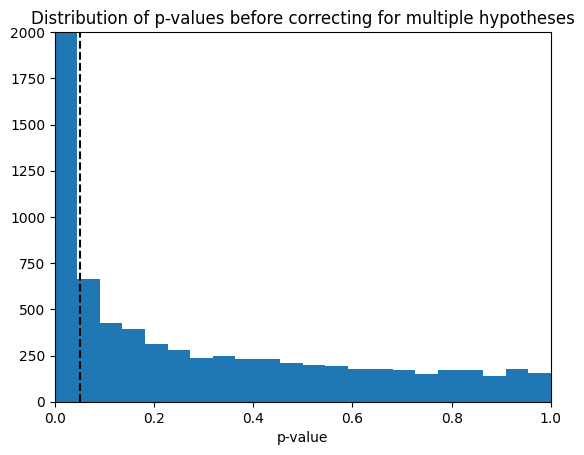

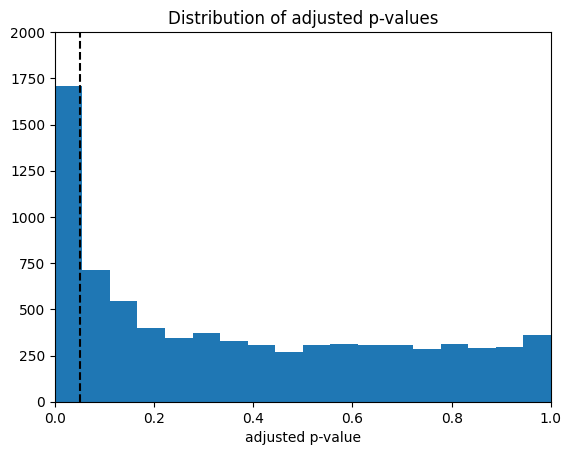

In [37]:
plt.hist(np.ndarray.tolist(p), bins='auto')
plt.axvline(x=0.05, linestyle="--", color="black")
plt.title("Distribution of p-values before correcting for multiple hypotheses")
plt.xlabel("p-value")
plt.xlim([0, 1])
plt.ylim([0,2000])
plt.show()

plt.hist(np.ndarray.tolist(p_adj), bins='auto')
plt.axvline(x=0.05, linestyle="--", color="black")
plt.title("Distribution of adjusted p-values")
plt.xlabel("adjusted p-value")
plt.xlim([0, 1])
plt.ylim([0,2000])
plt.show()

Let's plot adjusted p-values compared to p-values and see visually what happens in a bit more detail. For this figure, we will bound the figure limits by 1, however, note that adjusting p-values leads to values much higher than this.

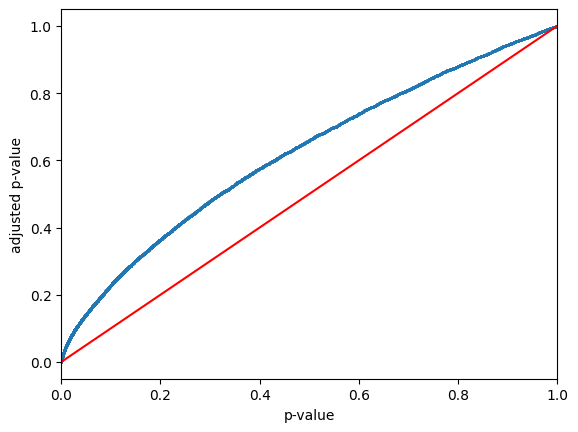

In [38]:
plt.scatter(p, p_adj, s=1)
plt.xlim([0, 1])
#plt.axvline(x=0.05, linestyle="--", color="black")
plt.plot([0,1],[0,1], c='red')
plt.ylabel("adjusted p-value")
plt.xlabel("p-value")
plt.show()

Each point on the red line indicates a scenario where the adjusted p-value is the same as the unadjusted p-value. **Points above** this line indicate cases where the **adjusted p-value is greater** than the unadjusted p-value, while points below the line indicate cases where the adjusted p-value is smaller than the unadjusted p-value.

### Defining a fold-change cutoff and get mean Log2-transformed fold-changes for Luminal A vs Luminal B

Now that we have adjusted our statistical confidence for the number of statistical tests we performed, the next thing to do is to assert a fold-**change**. We assume that **anything strongly upregulated or downregulated in Luminal A vs Luminal B is important** for the underlying biology. Perhaps in luminal A, some signaling pathway or set of transcription factors is strongly upregulated to promote cancer cell proliferation or metastisis.

Here we will say that anything that changes over **2-fold** is significant and worth additonal analysis or some sort of follow up. We can also relax or increase the fold-change, or specify the value relative to the standard deviation of fold-changes.

First, we calculate the **mean protein expression between the two groups **for each of the 7,000+ quantified proteins:

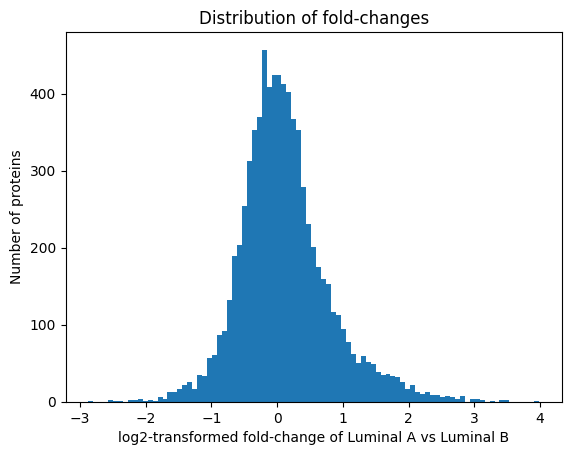

In [39]:
log2fc = np.mean(Lum_A, axis=1) - np.mean(Lum_B, axis=1)
#print(log2fc)

plt.hist(log2fc, bins='auto')
plt.title("Distribution of fold-changes")
plt.xlabel("log2-transformed fold-change of Luminal A vs Luminal B")
plt.ylabel('Number of proteins')
plt.show()

fc_cutoff = 2.0

### Get the list of differentially expressed proteins

Now let's get the list of proteins that meets both our criteria for statistical significance and fold change.
Given that we have multiple testing we need to take that into account when considering statitcal significance.


In [40]:
de_genes = np.logical_and(p_adj < 0.05, np.abs(log2fc) > np.log2(fc_cutoff))
de_genes_unadjusted = np.logical_and(p < 0.05, np.abs(log2fc) > np.log2(fc_cutoff))

Let's now plot what changes in between these two subtypes of breast cancer for the corrected data with our adjusted p-values and fold-changes.

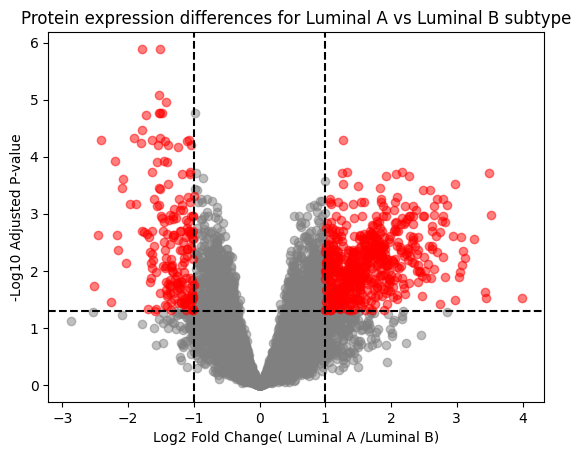

In [41]:
fig, ax = plt.subplots()
ax.scatter(log2fc[~de_genes], -np.log10(p_adj[~de_genes]), c="gray", alpha=0.5)
ax.scatter(log2fc[de_genes], -np.log10(p_adj[de_genes]), c="red", alpha=0.5)
ax.axvline(x=np.log2(fc_cutoff), linestyle="--", color="black")
ax.axvline(x=-np.log2(fc_cutoff), linestyle="--", color="black")
ax.axhline(y=-np.log10(0.05), linestyle="--", color="black")
ax.set_xlabel("Log2 Fold Change( Luminal A /Luminal B)")
ax.set_ylabel("-Log10 Adjusted P-value")
ax.set_title("Protein expression differences for Luminal A vs Luminal B subtype")
plt.show()

Let's plot what changes in between these two subtypes of breast cancer when no correction is applied:

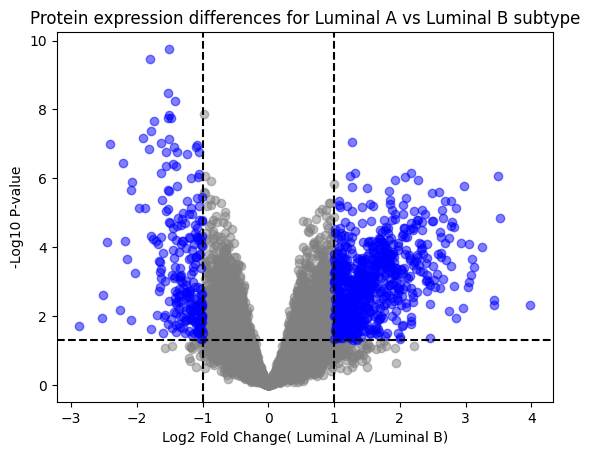

In [42]:
fig, ax = plt.subplots()
ax.scatter(log2fc[~de_genes_unadjusted], -np.log10(p[~de_genes_unadjusted]), c="gray", alpha=0.5)
ax.scatter(log2fc[de_genes_unadjusted], -np.log10(p[de_genes_unadjusted]), c="blue", alpha=0.5)
ax.axvline(x=np.log2(fc_cutoff), linestyle="--", color="black")
ax.axvline(x=-np.log2(fc_cutoff), linestyle="--", color="black")
ax.axhline(y=-np.log10(0.05), linestyle="--", color="black")
ax.set_xlabel("Log2 Fold Change( Luminal A /Luminal B)")
ax.set_ylabel("-Log10 P-value")
ax.set_title("Protein expression differences for Luminal A vs Luminal B subtype")
plt.show()

The plots look pretty similar, but when we use corrected values, we end up excluding a number of proteins as no longer significant. Indeed, now over 100 proteins have been excluded due to our correction for multiple hypothesis testing.

In [43]:
de_genes.sum()

740

In [44]:
de_genes_unadjusted.sum()

903

**<span style="font-size:large;"><u>Question 3</u></span>**:: <span style="font-size:large;">What happens if we are more stringent with or FDR cutoff? Let's now set the FDR to 1.0% cutoff?</span>

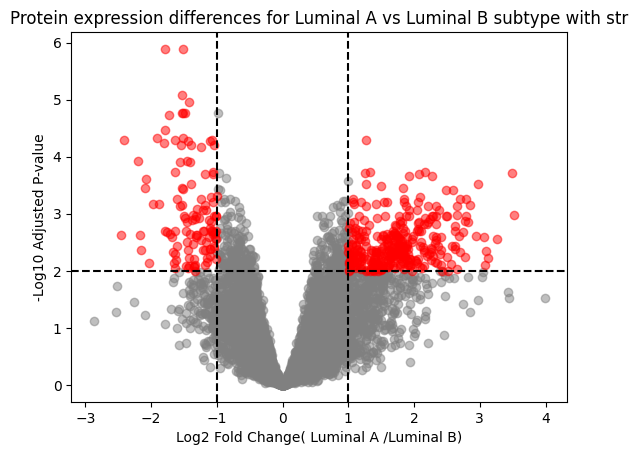

445

In [45]:
de_genes = np.logical_and(p_adj < 0.01, np.abs(log2fc) > np.log2(fc_cutoff))

fig, ax = plt.subplots()
ax.scatter(log2fc[~de_genes], -np.log10(p_adj[~de_genes]), c="gray", alpha=0.5)
ax.scatter(log2fc[de_genes], -np.log10(p_adj[de_genes]), c="red", alpha=0.5)
ax.axvline(x=np.log2(fc_cutoff), linestyle="--", color="black")
ax.axvline(x=-np.log2(fc_cutoff), linestyle="--", color="black")
ax.axhline(y=-np.log10(0.01), linestyle="--", color="black")
ax.set_xlabel("Log2 Fold Change( Luminal A /Luminal B)")
ax.set_ylabel("-Log10 Adjusted P-value")
ax.set_title("Protein expression differences for Luminal A vs Luminal B subtype with str")
plt.show()

de_genes.sum()

Let's now get the differentially expressed proteins as their own dataframe so we can look for biological significance between the two cancer subtypes:

**<span style="font-size:large;"><u>Group activity</u></span>**:Let's examine the proteins that show the most significant changes in the comparison between Luminal A and Luminal B subtypes. Explore these proteins either individually or collaboratively, using PubMed (or directly with Google). Can you identify the roles of these proteins in driving the differences observed between Luminal A and Luminal B cancer subtypes?

In [46]:
# add differentially expressed genes, fold change, and adj-pvalues to the original df

# provide the full table without filtering...

df['de_genes'] = np.array(de_genes) # true/false column
df['log2fc'] = np.array(log2fc)
df['adj_p'] = np.array(p_adj)

#get subset df where we only have differential expressed genes
DE_df = df.loc[df['de_genes'] == True]


In [47]:
DE_df.sort_values('log2fc', ascending=True).head(5)

,id,geneSymbol,numColumnsProteinObserved,numSpectraProteinObserved,protein_mw,percentCoverage,numPepsUnique,scoreUnique,species,accession_number,...,Basal.28,Her2.13,LumB.16,LumA.53,LumA.54,LumA.55,LumA.56,de_genes,log2fc,adj_p
9339,NP_003477.4,SLC7A5,17,67,55693.8,9.8,6,89.05,HOMO SAPIENS,NP_003477.4,...,0.9041,-4.9241,-2.6502,-1.6492,-4.2036,0.0847,-3.7330,True,-2.459072,0.002366
9078,NP_055551.1,KIAA0101,16,86,12100.4,72.9,8,106.03,HOMO SAPIENS,NP_055551.1,...,4.2485,-0.6173,0.2360,-0.9035,-3.1421,-2.5013,-1.0967,True,-2.407174,0.000051
10012,NP_001288754.1,AZIN2,15,22,52968.9,10.4,4,34.90,HOMO SAPIENS,NP_001288754.1,...,1.6466,-5.2662,0.7977,0.0787,-0.3564,-2.1272,-0.5658,True,-2.207043,0.000118
2506,NP_002849.1,ABCD3,17,658,75988.0,56.9,42,674.61,HOMO SAPIENS,NP_002849.1,...,0.3528,-3.9084,1.7390,1.3129,0.4947,-0.1311,0.3528,True,-2.176014,0.002312
2298,NP_001867.2,CPT1A,17,528,89050.7,64.2,48,717.59,HOMO SAPIENS,NP_001867.2,...,-1.0395,-0.7923,1.2891,-1.5311,-3.6912,2.6995,-1.7707,True,-2.148153,0.004401


In [48]:
DE_df.sort_values('log2fc', ascending=True).tail(5)

,id,geneSymbol,numColumnsProteinObserved,numSpectraProteinObserved,protein_mw,percentCoverage,numPepsUnique,scoreUnique,species,accession_number,...,Basal.28,Her2.13,LumB.16,LumA.53,LumA.54,LumA.55,LumA.56,de_genes,log2fc,adj_p
5293,NP_037541.1,FST,17,251,40174.6,66.8,22,358.29,HOMO SAPIENS,NP_037541.1,...,-0.1676,7.7630,-0.3438,0.8770,2.3308,-3.3393,0.0515,True,3.096272,0.004538
1353,NP_001159907.1,ITIH1,17,35,69665.3,45.5,27,485.89,HOMO SAPIENS,NP_001159907.1,...,0.7859,2.2734,-1.3033,-1.3341,5.0601,-0.0088,0.1052,True,3.129401,0.005933
968,NP_000086.2,COMP,17,1439,85483.6,76.3,57,1131.87,HOMO SAPIENS,NP_000086.2,...,-3.3151,6.3388,-2.1822,0.5776,1.7042,-0.4008,1.6352,True,3.255363,0.002758
2244,NP_077727.3,OGN,17,2212,40894.6,70.7,42,726.49,HOMO SAPIENS,NP_077727.3,...,-1.7737,2.8913,-0.8067,1.6254,2.1012,2.8686,0.1082,True,3.489539,0.000197
5963,NP_008966.1,KERA,17,171,40907.6,66.1,22,308.91,HOMO SAPIENS,NP_008966.1,...,-2.9072,-0.1797,-3.6695,1.8223,7.8379,-1.7640,-1.8452,True,3.517908,0.001055


# What happens between Basal and Her2 subtypes
We will make some changes, and specifiy different cutoffs here
For the class, let's change the values

[0.4721778  0.71114113 0.75917185 ... 0.57163102 0.86283322 0.13477873]


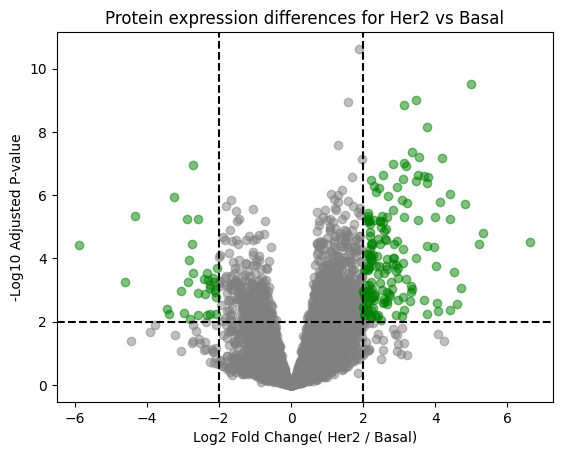

197

In [49]:
# get Basal and Her2 values
Basal = df.filter(like = 'Basal')
Her2 = df.filter(like = 'Her2')

# get log2FC values
log2fc = np.mean(Her2, axis=1) - np.mean(Basal, axis=1)

# perform t-test
t, p = ttest_ind(Basal, Her2, axis=1)
print(p)

# get corrected p-values
p_adj = statsmodels.stats.multitest.multipletests(p, method='fdr_bh')[1]
fc_cutoff = 4
de_genes = np.logical_and(p_adj < 0.01, np.abs(log2fc) > np.log2(fc_cutoff))

fig, ax = plt.subplots()
ax.scatter(log2fc[~de_genes], -np.log10(p_adj[~de_genes]), c="gray", alpha=0.5)
ax.scatter(log2fc[de_genes], -np.log10(p_adj[de_genes]), c="green", alpha=0.5)
ax.axvline(x=np.log2(fc_cutoff), linestyle="--", color="black")
ax.axvline(x=-np.log2(fc_cutoff), linestyle="--", color="black")
ax.axhline(y=-np.log10(0.01), linestyle="--", color="black")
ax.set_xlabel("Log2 Fold Change( Her2 / Basal)")
ax.set_ylabel("-Log10 Adjusted P-value")
ax.set_title("Protein expression differences for Her2 vs Basal")
plt.show()

de_genes.sum()

**<span style="font-size:large;"><u>Question 4</u></span>**: <span style="font-size:large;">What can we say between the two comparisons about the differences between breast cancer subtypes? Even at a high level? Note that we increased the cutoff to a +/- 4-fold change in abundance.</span>



### Answer 4:

There are some stark changes between tumor subtypes as signalled by the presnce of 200-700 differentially expressed proteins. This can be the hallmark of different tumor strategies and the reason beheind the variable tratments for tumors.

Also, did you notice the mistake in the code of the exercise notebook? In the last figure the y axis arrived to the negatives, which is impossible. If it's not clear why please ask your tutors.

## Making sense of quantitative changes

**<span style="font-size:large;"><u>Question 5</u></span>**: <span style="font-size:large;">What might make sense for statistical cutoffs/thresholds if we had an even larger dataset (~20,000 genes instead of ~7,000 proteins)? Should we relax our adjusted p-value cutoff?</span><br>

**<span style="font-size:large;"><u>Question 6</u></span>**: <span style="font-size:large;">How do we prioritize or move forward with our results? Let's assume, like the authors, we are trying to better understand the biology of breast cancer subtypes.</span><br>

**<span style="font-size:large;"><u>Question 7</u></span>**: <span style="font-size:large;">Should we examine results at the level of single proteins, or connect their role(s) to different pathways?</span><br>

**<span style="font-size:large;"><u>Question 8</u></span>**: <span style="font-size:large;">Should we expect proteins involved in the same biological process to change? What about protein complexes?</span><br>

**<span style="font-size:large;"><u>Question 9</u></span>**: <span style="font-size:large;">In the case of Her2 breast cancer, we know that Human Epidermal Growth Factor Receptor 2 (HER2) is activated. Alone or in a group, write pseudocode to layer proteins in the epidermal growth factor pathway on top of the above volcano plot.<br>
Do you expect proteins in this pathway to be significantly different between HER2 and Basal breast cancer subtypes?</span><br>

### Answers 5-9

5) The more hypotheses we test the more we need to be sure of correcting for mutiple tests. The cuotffs on our corrected p-values should reflect our aim for the study, if we want to generate hypotheses or have already relevant (but fewer) results.

6) We could look in literature for the physiological functions of the altered proteins, this could give us insioghts on the mechanistic changes among tumors.

7) We might want to look at pathway-level and connections between biological modules/pathways to obtain a more physiologically relevant picture of the changes.

8) Yes, since proteins participate in biological pathways either in metabolism, signaling, replication, etc, we could expect proteins in a biological process activated in a particular setting. However we must keep an open mind to what the data tells us and not force what we want to see in it.

9) Generate volcano plot in the same way (p-values, fold-changes); annotate entries that are in this pathway and visualize where they fall on the volcano plot; look at either the total number or the magnitude or direction of change to see what conclusions can be drawn. Yes, we expect proteins in this pathway to be different between cancer subtypes.

In [50]:
# add differentially expressed genes, fold change, and adj-pvalues to the original df

# provide the full table without filtering...

df['de_genes'] = np.array(de_genes) # true/false column
df['log2fc'] = np.array(log2fc)
df['adj_p'] = np.array(p_adj)

#get subset df where we only have differential expressed genes
DE_df = df.loc[df['de_genes'] == True]


In [51]:
#let's have a look at ERBB2, commonly referred to as HER2
df[df.geneSymbol.str.contains('ERBB2')]

,id,geneSymbol,numColumnsProteinObserved,numSpectraProteinObserved,protein_mw,percentCoverage,numPepsUnique,scoreUnique,species,accession_number,...,Basal.28,Her2.13,LumB.16,LumA.53,LumA.54,LumA.55,LumA.56,de_genes,log2fc,adj_p
952,NP_004439.2,ERBB2,17,922,141274.2,64.3,66,1140.69,HOMO SAPIENS,NP_004439.2,...,-4.7046,-4.9453,0.5064,-2.3005,-3.3276,2.4729,-3.3185,True,4.702337,0.000838


[0.4721778  0.71114113 0.75917185 ... 0.57163102 0.86283322 0.13477873]


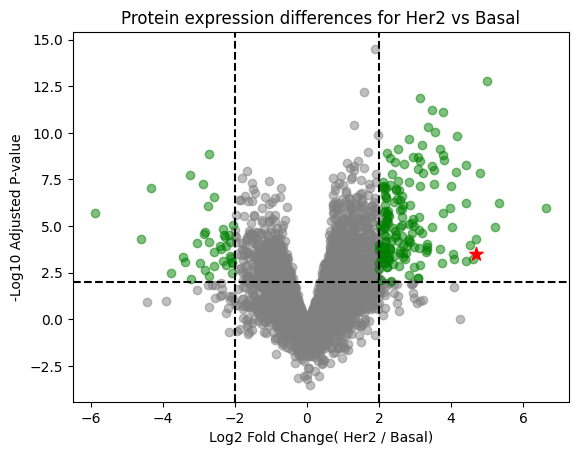

In [52]:
# get Basal and Her2 values
Basal = df.filter(like = 'Basal')
Her2 = df.filter(like = 'Her2')

# get log2FC values
log2fc = np.mean(Her2, axis=1) - np.mean(Basal, axis=1)

# perform t-test
t, p = ttest_ind(Basal, Her2, axis=1)
print(p)

# get corrected p-values
p_adj = np.multiply(p, len(p) / np.arange(len(p), 0, -1))

fc_cutoff = 4
de_genes = np.logical_and(p_adj < 0.01, np.abs(log2fc) > np.log2(fc_cutoff))

fig, ax = plt.subplots()
ax.scatter(log2fc[~de_genes], -np.log10(p_adj[~de_genes]), c="gray", alpha=0.5)
ax.scatter(log2fc[de_genes], -np.log10(p_adj[de_genes]), c="green", alpha=0.5)
ax.axvline(x=np.log2(fc_cutoff), linestyle="--", color="black")
ax.axvline(x=-np.log2(fc_cutoff), linestyle="--", color="black")
ax.axhline(y=-np.log10(0.01), linestyle="--", color="black")
ax.set_xlabel("Log2 Fold Change( Her2 / Basal)")
ax.set_ylabel("-Log10 Adjusted P-value")
ax.set_title("Protein expression differences for Her2 vs Basal")

# Highlight HER2 (=ERBB2) protein in red
her2_index = df.index[df['geneSymbol'].str.contains('ERBB2')][0]  # Get the index of HER2 protein
her2_log2fc = log2fc[her2_index]  # Get the log2 fold change for HER2
her2_padj = p_adj[her2_index]  # Get the adjusted p-value for HER2

# Plot HER2 point in red
ax.scatter(her2_log2fc, -np.log10(her2_padj), c="red", marker="*", s=100, label="HER2")

plt.show()


In [53]:
print(DE_df)

                  id geneSymbol  numColumnsProteinObserved  \
33    NP_001074419.1      MYO1C                         17   
73       NP_004095.4       FASN                         17   
90       NP_006624.2     IQGAP2                         17   
128      NP_942133.1      ACACA                         17   
144      NP_002408.3      MKI67                         17   
...              ...        ...                        ...   
9309  NP_001244320.1       CD63                         17   
9437  NP_001245249.1    TP53I11                         17   
9473  NP_001034579.1      CD151                         17   
9610     NP_055214.1    TSPAN13                         17   
9685     NP_004330.1    PTTG1IP                         16   

      numSpectraProteinObserved  protein_mw  percentCoverage  numPepsUnique  \
33                           26    120424.7             81.7            115   
73                         7494    276046.1             84.7            208   
90                